# Using the COSIMA Cookbook for ACCESS-OM2 Analysis

This notebook outlines a brief tutorial to help you analyse some ACCESS-OM2 output with the COSIMA Cookbook. It assumes that:
 * You have access to the COSIMA cookbook, preferably through the `conda/analysis3-19.04` (or later) module on the [Virtual Desktop Infrastructure (VDI)](http://nci.org.au/services/vdi/) at NCI.
 * You can fire up a Jupyter notebook!

**Before starting,** load in some standard libraries that you are likely to need:

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs

In addition, you **always** need to load the cosima_cookbook module. This provides a bunch of functions that you will use:

In [4]:
import cosima_cookbook as cc

## 1. The Cookbook Philosophy
The COSIMA Cookbook is a framework for analysing ocean-sea ice model output.
It is designed to:
* Provide examples of commonly used diagnostics;
* Write efficient, well-documented, openly accessible code;
* Encourage community input to the code;
* Ensure diagnostic results are reproducible;
* Process diagnostics directly from the model output, minimising creation of intermediate files;
* Find methods to deal with the memory limitations of analysing high-resolution model output.


### 1.1 A database of experiments
The COSIMA Cookbook relies on a database of experiments in order to load model output. This database effectively holds metadata for each experiment, as well as variable names, data ranges and so on. To access the database for this workshop, you need to start a database session each time you fire up a notebook:

In [5]:
db = '/g/data3/hh5/tmp/cosima/database/clex-winter-school.db'
session = cc.database.create_session(db)

### 1.2 Loading data from a netcdf file

Python has many ways of reading in data from a netcdf file ... so we thought we would add another way. This is achieved in the `querying.getvar()` function, which is the most commonly used function in the cookbook. This function queries the database to find a specific variable, and loads some or all of that file. We will now take a little while to get to know this function. In it's simplest form, you need just three arguments: expt, variable and database. 

You can see all the available options using the inbuilt help function, which brings up the function documentation.

In [6]:
help(cc.querying.getvar)

Help on function getvar in module cosima_cookbook.querying:

getvar(expt, variable, session, ncfile=None, n=None, start_time=None, end_time=None, chunks=None, time_units=None, offset=None, decode_times=True, check_present=False)
    For a given experiment, return an xarray DataArray containing the
    specified variable.
    
    expt - text string indicating the name of the experiment
    variable - text string indicating the name of the variable to load
    session - a database session created by cc.database.create_session()
    
    ncfile - If disambiguation based on filename is required, pass the ncfile
    argument.
    n - A subset of output data can be obtained by restricting the number of 
        netcdf files to load (use a negative value of n to get the last n 
        files, or a positive n to get the first n files).
    start_time - Only load data after this date. Specify the date as a text string
        (e.g. '1900-1-1')
    start_time - Only load data before this date. 

You may like to note a few things about this function:
1. The data is returned as an xarray DataArray, which includes the coordinate and attribute information from the netcdf file (more on xarray later). 
2. The variable time does not start at zero - and if you don't like it you can introduce an offset to alter the time axis.
3. By default, we load the whole dataset, but we can load a subset of the times (see below).
4. Other customisable options include setting the variable chunking and incorporating a function to operate on the data.

In [7]:
expt = '1deg_jra55_ryf9091_kds50_july_bkd'
variable = 'temp_global_ave'
darray = cc.querying.getvar(expt,variable,session)
darray

<xarray.DataArray 'temp_global_ave' (time: 7200, scalar_axis: 1)>
dask.array<shape=(7200, 1), dtype=float32, chunksize=(1, 1)>
Coordinates:
  * scalar_axis  (scalar_axis) float64 0.0
  * time         (time) object 1900-01-16 12:00:00 ... 2499-12-16 12:00:00
Attributes:
    long_name:      Global mean temp in liquid seawater
    units:          deg_C
    valid_range:    [ -10. 1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

You can see that this operation loads the globally averaged potential temperature  from the model output. The time axis runs from year 1900 to 2500. For some variables (particularly 3D variables that might use a lot of memory) you may prefer to restrict yourself to a smaller time window:

In [9]:
darray = cc.querying.getvar(expt,variable,session,
                            start_time='2000-01-01',
                            end_time='2049-12-31')
darray

<xarray.DataArray 'temp_global_ave' (time: 720, scalar_axis: 1)>
dask.array<shape=(720, 1), dtype=float32, chunksize=(1, 1)>
Coordinates:
  * scalar_axis  (scalar_axis) float64 0.0
  * time         (time) object 1990-01-16 12:00:00 ... 2049-12-16 12:00:00
Attributes:
    long_name:      Global mean temp in liquid seawater
    units:          deg_C
    valid_range:    [ -10. 1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

## 2. How to manipulate and plot variables with xarray
We use the python package `xarray` (which is built on `dask`, `pandas`, `matplotlib` and `numpy`) for many of our diagnostics. `xarray` has a a lot of nice features, some of which we will try to demonstrate for you. 

### 2.1 Plotting
`xarray`'s `.plot()` method does its best to figure out what you are trying to plot, and plotting it for you. Let's start by loading a 1-dimensional variable and plotting.

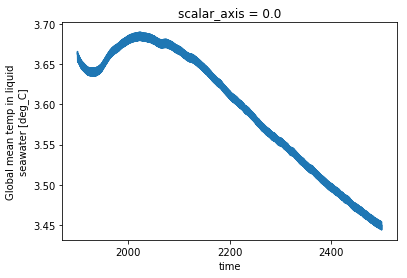

In [10]:
expt = '1deg_jra55_ryf9091_kds50_july_bkd'
variable = 'temp_global_ave'
darray = cc.querying.getvar(expt,variable,session)
darray.plot()

In [11]:
darray

<xarray.DataArray 'temp_global_ave' (time: 7200, scalar_axis: 1)>
dask.array<shape=(7200, 1), dtype=float32, chunksize=(1, 1)>
Coordinates:
  * scalar_axis  (scalar_axis) float64 0.0
  * time         (time) object 1900-01-16 12:00:00 ... 2499-12-16 12:00:00
Attributes:
    long_name:      Global mean temp in liquid seawater
    units:          deg_C
    valid_range:    [ -10. 1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

You should see that `xarray` has figured out that this data is a timeseries, that the x-axis is representing time and that the y-axis is `temp_global_ave`. You can always modify aspects of your plot if you are unhappy with the default xarray behaviour:

Text(0.5,1,'Globally Averaged Temperature')

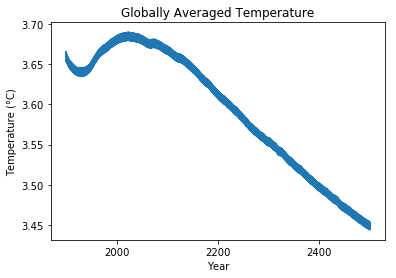

In [12]:
darray.plot()
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Globally Averaged Temperature')

Because `xarray` knows about dimensions, it has plotting routines which can figure out what it should plot. By way of example, let's load `sea_level`, average in time and see how `.plot()` handles it: 

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


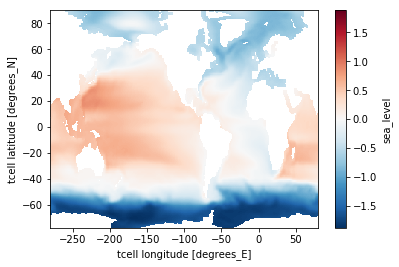

In [17]:
expt = '1deg_jra55_ryf9091_kds50_july_bkd'
variable = 'sea_level'
darray = cc.querying.getvar(expt,variable,session,start_time='2400-01-01')
SSH = darray.mean('time')
SSH.plot()

Again, you can customise this plot as you see fit:

Text(0.5,0,'longitude')

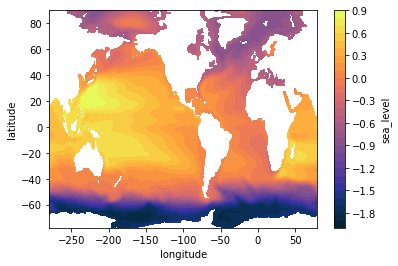

In [18]:
SSH.plot.contourf(levels=np.arange(-2,1,0.1),cmap=cm.cm.thermal)
plt.ylabel('latitude')
plt.xlabel('longitude')

### 2.2 Slicing and dicing

There are two different ways of subselecting from a DataArray: `isel` and `sel`. The first of these is probably what you are used to -- you specify the value of the index of the array. In the second case you specify the value of the coordinate you want to select. These two methods are demonstrated in the following example:

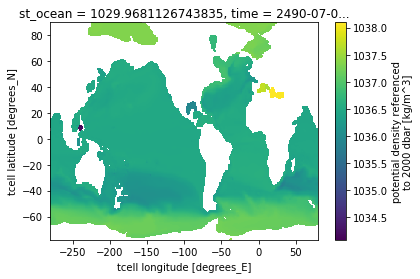

In [23]:
darray = cc.querying.getvar('1deg_jra55_ryf9091_kds50_july_bkd','pot_rho_2',session,start_time='2400-01-01')
density = darray.isel(time=100).sel(st_ocean=1000,method='nearest')
density.plot()

In the above example, 100 years of the dataset is loaded. We then use `isel` to select the 101st year (timeindex of 100) and use `sel` to select a z level that is about 1000m deep. The `sel` method is very flexible, allowing us to use similar code in differing model resolutions or grids. In addition, both methods allow you to slice a range of values:

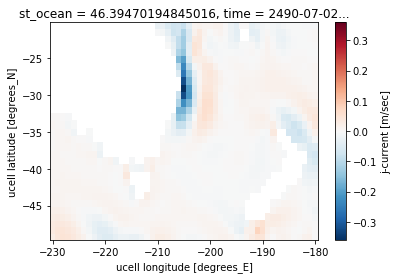

In [26]:
darray = cc.querying.getvar('1deg_jra55_ryf9091_kds50_july_bkd','v',session,start_time='2400-01-01')
v = darray.isel(time=100).sel(st_ocean=50,method='nearest')\
            .sel(yu_ocean=slice(-50,-20)).sel(xu_ocean=slice(-230,-180))
v.plot()

Here we have taken meridional velocity, and sliced out a small region of interest for our plot.

### 2.3 Averaging along dimensions

We often perform operations such as averaging on dataarrays. Again, knowledge of the coordinates can be a big help here, as you can instruct the `mean()` method to operate along given coordinates. The case below takes a temporal and zonal average of potential density. (To be precise, it is actually a mean in the i grid direction, which is only zonal outside the tripolar region in the Arctic, i.e. south of 65N in the ACCESS-OM2 models.)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


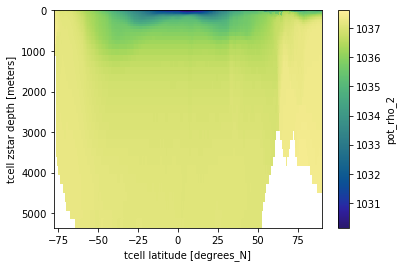

In [27]:
darray = cc.querying.getvar('1deg_jra55_ryf9091_kds50_july_bkd','pot_rho_2',session,start_time='2400-01-01')
darray.mean('time').mean('xt_ocean').plot(cmap=cm.cm.haline)
plt.gca().invert_yaxis()

### 2.4 Resampling

`xarray` uses `datetime` conventions to allow for operations such as resampling in time. This resampling is simple and powerful. Here is an example of re-plotting the figure from 2.1 with annual averaging:

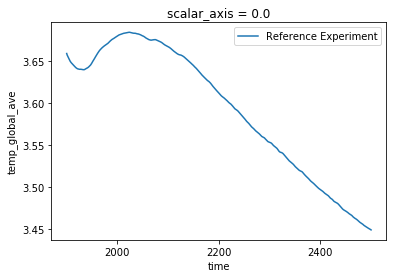

In [33]:
darray = cc.querying.getvar('1deg_jra55_ryf9091_kds50_july_bkd','temp_global_ave',session)
meandata = darray.resample(time='A').mean(dim='time')
meandata.plot(label='Reference Experiment')
plt.legend()

## 3. More Advanced Stuff

### 3.1 Making a map with cartopy

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


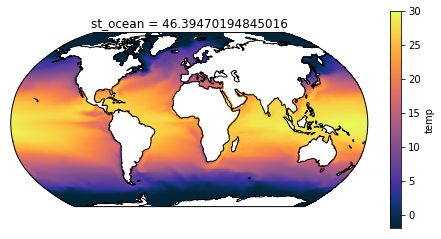

In [30]:
darray = cc.querying.getvar('1deg_jra55_ryf9091_kds50_july_bkd','temp',session,start_time='2400-01-01')
temp = darray.mean('time').sel(st_ocean=50,method='nearest') - 273.15
plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.Robinson())
temp.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),x='xt_ocean', y='yt_ocean',cmap=cm.cm.thermal,vmin=-2,vmax=30)
ax.coastlines()

## 4. Your Task for Today

### 4.1 Data

I have prepared three experiments for you. The experiments are as follows:

| Experiment name | Description |
|-----------------|-------------|
|`1deg_jra55_ryf9091_kds50_july_bkd`| This is a long, 600-year spinup experiment. It uses the 1° version of ACCESS-OM2. The atmospheric state involves a repeating year (taken from May 1990 to April 1991), representing a generic forcing year.|
|`1deg_jra55_SAMextr_ryf0203_from9091_kds50` | This is a perturbed simulation which branches off the spinup experiment at year XX. The perturbation involves using the atmopsheric state from 2002-2003 -- which had a strongly negative Southern Annular Mode index (weak Southern Hemisphere westerlies). |
|`1deg_jra55_SAMextr_ryf9899_from9091_kds50` | This is a perturbed simulation which branches off the spinup experiment at year XX. The perturbation involves using the atmopsheric state from 1998-1999 -- which had a strongly positive Southern Annular Mode index (strong Southern Hemisphere westerlies).

**Your task (if you choose to accept it) is to investigate the effect that the perturbation had on the ocean or sea ice.**

### 4.2 Variables
Here is a list of variables that have been saved from the model which you might find useful:

| Variable name | Dimensions | Description |
|---------------|------------|-------------|
| ke_tot | time | Globally integrated ocean kinetic energy |
| pe_tot | time | Globally integrated ocean potential energy |
| temp_global_ave | time | Global mean temp in liquid seawater |
| salt_global_ave | time | Global mean salt in liquid seawater |
| rhoave | time | global mean ocean in-situ density from ocean_density_mod|
| temp_surface_ave | time | Global mass weighted mean surface temp in liquid seawater |
| salt_surface_ave | time | Global mass weighted mean surface salt in liquid seawater |
| eta_global | time | global ave sea level | 
| total_net_sfc_heating | time | total ocean surface flux from coupler and mass transfer |
| total_ocean_pme_river | time | total ocean precip-evap+river via sbc (liquid, frozen, evaporation | 
| total_ocean_evap | time | total evaporative ocean mass flux (>0 enters ocean) |
|  
| sea_level | (time, Y, X) | effective sea level on T cells | 
| sea_levelsq | (time, Y, X) | square of effective sea level on T cells |
| mld | (time, Y, X) | mixed layer depth determined by density criteria | 
| sfc_salt_flux_coupler | (time, Y, X)  | sfc_salt_flux_coupler: flux from the coupler|
| net_sfc_heating | (time, Y, X) | surface ocean heat flux coming through coupler and mass transfer |
| tau_x | (time, Y, X) | i-directed wind stress forcing u-velocity | 
| tau_y | (time, Y, X) | j-directed wind stress forcing v-velocity |
| tx_trans_int_z | (time, Y, X) | T-cell i-mass transport vertically summed |
| ty_trans_int_z | (time, Y, X) | T-cell j-mass transport vertically summed |
|
| hi_m | (time, Y, X) | grid cell mean ice thickness |
| hs_m | (time, Y, X)  | grid cell mean snow thickness|
| aice_m | (time, Y, X) |ice area  (aggregate) |
|
| temp | (time, Z, Y, X) | Conservative temperature | 
| salt | (time, Z, Y, X) | Practical Salinity |
| age_global | (time, Z, Y, X) | Age (global) |
| u | (time, Z, Y, X) | i-current | 
| v | (time, Z, Y, X) | j-current|
| pot_rho_0 | (time, Z, Y, X) | potential density referenced to 0 dbar |
| pot_rho_2 | (time, Z, Y, X) | potential density referenced to 2000 dbar | 
| tx_trans | (time, Z, Y, X) | T-cell i-mass transport | 
| ty_trans | (time, Z, Y, X) | T-cell j-mass transport | 
| tx_trans_rho | (time, rho, Y, X) | T-cell i-mass transport on pot_rho |
| ty_trans_rho | (time, rho, Y, X) | T-cell j-mass transport on pot_rho |
| ty_trans_rho_gm | (time, rho, Y, X) | T-cell j-mass transport from GM on pot_rho | 
| temp_xflux_adv | (time, Z, Y, X) | cp.rho.dzt.dyt.u.temp |
| temp_yflux_adv | (time, Z, Y, X) | cp.rho.dzt.dxt.v.temp |

### 4.3 Have a go yourself
Now it's time for you to learn how to plot some output from these experiments. My suggestion is that you start slowly:
 * Plot a timeseries of your choice from each of the 3 experiments, on the same axes;
 * Plot time-mean 2D variable;
 * Plot the difference between two fields from different experiments;
 * Show that the wind stress in the perturbation cases is different to the wind stress in the reference case.
 
### 4.4 Now that you know how to plot things ...
Think of what you would like to investigate in these runs. Discuss with your group as to what you might be able to learn, and how you would do the analysis. Then, make a few plots for me. Try to make it stylish, choose a good colour scale. Then, be ready to show your plot to the whole group and to explain what it means...

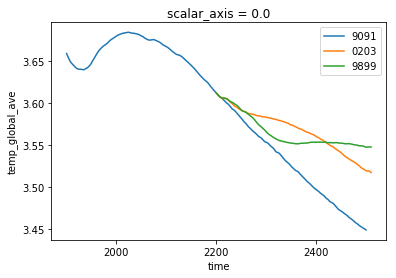

In [32]:
darray = cc.querying.getvar('1deg_jra55_ryf9091_kds50_july_bkd','temp_global_ave',session)
meandata = darray.resample(time='A').mean(dim='time')
meandata.plot(label='9091')
darray = cc.querying.getvar('1deg_jra55_SAMextr_ryf0203_from9091_kds50','temp_global_ave',session)
meandata = darray.resample(time='A').mean(dim='time')
meandata.plot(label='0203')
darray = cc.querying.getvar('1deg_jra55_SAMextr_ryf9899_from9091_kds50','temp_global_ave',session)
meandata = darray.resample(time='A').mean(dim='time')
meandata.plot(label='9899')
plt.legend()

In [35]:
darray = cc.querying.getvar('1deg_jra55_ryf9091_kds50_july_bkd','hi_m',session)
ice = darray.mean('time')
ice.plot()

TypeError: zip argument #2 must support iteration